# SigLIP VLM — 6-Class Chest X-Ray Classification

Dataset: COVID-19, Bacterial Pneumonia, Normal, Tuberculosis (6 classes)

In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
# Install transformers if not available: pip install transformers
from transformers import SiglipVisionModel, SiglipImageProcessor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")

# Recursively search for a folder by name anywhere under base
def find_folder(base, folder_name, max_depth=5):
    base = Path(base)
    def _search(current, depth):
        if depth == 0:
            return None
        try:
            for entry in current.iterdir():
                if not entry.is_dir():
                    continue
                if entry.name == folder_name:
                    return entry
                result = _search(entry, depth - 1)
                if result:
                    return result
        except PermissionError:
            pass
        return None
    result = _search(base, max_depth)
    if result is None:
        raise FileNotFoundError(
            f"Could not find folder '{folder_name}' anywhere under {base}"
        )
    return result

covid_19   = find_folder(dataset, "COVID-19_Radiography_Dataset")
chest_xray = find_folder(dataset, "chest_xray")
tb_chest   = find_folder(dataset, "TB_Chest_Radiography_Database")

print(f"covid_19   = {covid_19}")
print(f"chest_xray = {chest_xray}")
print(f"tb_chest   = {tb_chest}")

covid_19   = /kaggle/input/datasets/tawsifurrahman/covid19-radiography-database/COVID-19_Radiography_Dataset
chest_xray = /kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray
tb_chest   = /kaggle/input/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database


## Data Loading

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """Append image file names from a directory to the class mapping."""
    directory = Path(directory)
    for f_name in os.listdir(directory):
        if f_name.lower().endswith((".jpeg", ".jpg", ".png")):
            class_mapping[cls_name].append(str(directory / f_name))

# COVID-19 dataset: each subfolder (COVID, Lung_Opacity, Normal, Viral Pneumonia)
# has an 'images' subdirectory
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    images_dir = covid_19 / covid19_class / 'images'
    if images_dir.exists():
        append_file_names(images_dir, covid19_class)
    else:
        # Some versions store images directly in the class folder
        append_file_names(covid_19 / covid19_class, covid19_class)

# Chest X-Ray dataset: only Bacterial Pneumonia (bacteria keyword in filename)
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test"  / "PNEUMONIA",
                  chest_xray / "val"   / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    if not source_dir.exists():
        print(f"Skipping (not found): {source_dir}")
        continue
    for filename in os.listdir(source_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            if "bacteria" in filename.lower():
                class_mapping["Bacterial Pneumonia"].append(str(source_dir / filename))

# TB dataset
tb_dir = tb_chest / "Tuberculosis"
if tb_dir.exists():
    append_file_names(tb_dir, "Tuberculosis")
else:
    print(f"TB directory not found: {tb_dir}")

print("Classes found:", list(class_mapping.keys()))
print("Counts:", {k: len(v) for k, v in class_mapping.items()})

class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Classes found: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Bacterial Pneumonia', 'Tuberculosis']
Counts: {'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345, 'COVID': 3616, 'Bacterial Pneumonia': 2780, 'Tuberculosis': 700}


Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 2710999.82it/s]


## Train/Val/Test Split

In [5]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=0.1111, random_state=42, stratify=remaining_labels
)

total_samples = len(labels_encoded)
print(f"Train: {len(train_paths)} ({len(train_paths)/total_samples*100:.2f}%)")
print(f"Val:   {len(val_paths)} ({len(val_paths)/total_samples*100:.2f}%)")
print(f"Test:  {len(test_paths)} ({len(test_paths)/total_samples*100:.2f}%)")

Train: 19715 (80.00%)
Val:   2465 (10.00%)
Test:  2465 (10.00%)


## Dataset & DataLoaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        transformed_img = self.transform(pil_img)
        label = self.img_labels[index]
        return transformed_img, label

In [7]:
BATCH_SIZE = 16
MODEL_NAME = "google/siglip-base-patch16-224"

# SigLIP requires specific pixel normalization — use the HF processor inside the dataset
siglip_processor = SiglipImageProcessor.from_pretrained(MODEL_NAME)

class SigLIPDataset(Dataset):
    """Dataset that applies the SiglipImageProcessor normalization."""
    def __init__(self, img_paths, img_labels):
        self.img_paths = img_paths
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        # Processor handles resize to 224x224 + normalization
        inputs = siglip_processor(images=pil_img, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3, 224, 224)
        label = self.img_labels[index]
        return pixel_values, label

train_dataset = SigLIPDataset(train_paths, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = SigLIPDataset(val_paths, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dataset = SigLIPDataset(test_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

## SigLIP VLM Model

In [8]:
MODEL_NAME = "google/siglip-base-patch16-224"

class SigLIPClassifier(nn.Module):
    """Wraps SiglipVisionModel with a classification head."""
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.vision_model = SiglipVisionModel.from_pretrained(model_name)
        hidden_size = self.vision_model.config.hidden_size  # 768 for base
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.vision_model(pixel_values=pixel_values)
        # Use the pooled output (mean of patch tokens)
        pooled = outputs.last_hidden_state.mean(dim=1)  # (B, hidden_size)
        logits = self.classifier(pooled)
        return logits

model = SigLIPClassifier(MODEL_NAME, num_classes)
model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SiglipVisionModel LOAD REPORT from: google/siglip-base-patch16-224
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.out_proj.bias   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.out_proj.weight | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.weight    

Layer (type:depth-idx)                                       Output Shape              Param #
SigLIPClassifier                                             [1, 6]                    --
├─SiglipVisionModel: 1-1                                     [1, 768]                  --
│    └─SiglipVisionTransformer: 2-1                          [1, 768]                  --
│    │    └─SiglipVisionEmbeddings: 3-1                      [1, 196, 768]             741,120
│    │    └─SiglipEncoder: 3-2                               [1, 196, 768]             85,054,464
│    │    └─LayerNorm: 3-3                                   [1, 196, 768]             1,536
│    │    └─SiglipMultiheadAttentionPoolingHead: 3-4         [1, 768]                  7,087,104
├─Linear: 1-2                                                [1, 6]                    4,614
Total params: 92,888,838
Trainable params: 92,888,838
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 205.69
Input size (MB): 0.60
Forward/backward 

## Metrics Function

In [9]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)
    auc_scores = []
    for class_idx in range(y_pred.shape[1]):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)
    auc_avg = np.mean(auc_scores)
    return {
        "loss": loss, "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1_score": f1, "specificity": specificity,
        "sensitivity": sensitivity, "mcc": mcc, "auc": auc_avg,
    }

## Training

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

num_epochs           = 25
total_training_time  = 0.0
total_validation_time = 0.0

# ── Early stopping ──────────────────────────────────────────────────────────
patience         = 5
patience_counter = 0
best_val_loss    = float("inf")
best_model_path  = "siglip_best_model.pth"
# ────────────────────────────────────────────────────────────────────────────

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{num_epochs}]"):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    total_training_time += end_time - start_time

    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    line = "Train - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(line)

    # Validation
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    val_start = time.time()
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f"Validation - Epoch [{epoch+1}/{num_epochs}]"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    total_validation_time += time.time() - val_start

    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    line = "Val   - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(line)

    scheduler.step()

    # ── Early stopping check ────────────────────────────────────────────────
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ Val loss improved to {best_val_loss:.4f} — model saved.")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience}). Best val loss: {best_val_loss:.4f}")
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1} (patience={patience}).")
            break
    # ────────────────────────────────────────────────────────────────────────

print(f"\nTotal Training Time:   {str(timedelta(seconds=int(total_training_time)))}")
print(f"Total Validation Time: {str(timedelta(seconds=int(total_validation_time)))}")

# Load best model for evaluation
print(f"\nLoading best model (val loss={best_val_loss:.4f}) for evaluation ...")
model.load_state_dict(torch.load(best_model_path, map_location=device))
print("Best model loaded.")


Training - Epoch [1/25]: 100%|██████████| 1233/1233 [06:32<00:00,  3.14it/s]


Train - loss: 0.2311, accuracy: 0.9172, precision: 0.9176, recall: 0.9172, f1_score: 0.9170, specificity: 0.9685, sensitivity: 0.9951, mcc: 0.8864, auc: 0.9810


Validation - Epoch [1/25]: 100%|██████████| 155/155 [00:23<00:00,  6.51it/s]


Val   - loss: 0.1795, accuracy: 0.9339, precision: 0.9419, recall: 0.9339, f1_score: 0.9342, specificity: 0.8058, sensitivity: 1.0000, mcc: 0.9107, auc: 0.9934
  ✓ Val loss improved to 0.1795 — model saved.


Training - Epoch [2/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.12it/s]


Train - loss: 0.1016, accuracy: 0.9653, precision: 0.9653, recall: 0.9653, f1_score: 0.9652, specificity: 0.9933, sensitivity: 0.9990, mcc: 0.9525, auc: 0.9960


Validation - Epoch [2/25]: 100%|██████████| 155/155 [00:16<00:00,  9.64it/s]


Val   - loss: 0.1333, accuracy: 0.9538, precision: 0.9547, recall: 0.9538, f1_score: 0.9540, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9371, auc: 0.9963
  ✓ Val loss improved to 0.1333 — model saved.


Training - Epoch [3/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.12it/s]


Train - loss: 0.0611, accuracy: 0.9793, precision: 0.9792, recall: 0.9793, f1_score: 0.9792, specificity: 0.9915, sensitivity: 0.9987, mcc: 0.9716, auc: 0.9986


Validation - Epoch [3/25]: 100%|██████████| 155/155 [00:16<00:00,  9.66it/s]


Val   - loss: 0.1532, accuracy: 0.9432, precision: 0.9449, recall: 0.9432, f1_score: 0.9437, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9227, auc: 0.9967
  No improvement (1/5). Best val loss: 0.1333


Training - Epoch [4/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.12it/s]


Train - loss: 0.0377, accuracy: 0.9877, precision: 0.9877, recall: 0.9877, f1_score: 0.9877, specificity: 0.9937, sensitivity: 0.9994, mcc: 0.9832, auc: 0.9994


Validation - Epoch [4/25]: 100%|██████████| 155/155 [00:16<00:00,  9.68it/s]


Val   - loss: 0.1560, accuracy: 0.9554, precision: 0.9554, recall: 0.9554, f1_score: 0.9550, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9391, auc: 0.9964
  No improvement (2/5). Best val loss: 0.1333


Training - Epoch [5/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.12it/s]


Train - loss: 0.0370, accuracy: 0.9881, precision: 0.9881, recall: 0.9881, f1_score: 0.9881, specificity: 0.9928, sensitivity: 0.9991, mcc: 0.9837, auc: 0.9995


Validation - Epoch [5/25]: 100%|██████████| 155/155 [00:16<00:00,  9.67it/s]


Val   - loss: 0.1311, accuracy: 0.9602, precision: 0.9608, recall: 0.9602, f1_score: 0.9600, specificity: 0.9928, sensitivity: 1.0000, mcc: 0.9458, auc: 0.9965
  ✓ Val loss improved to 0.1311 — model saved.


Training - Epoch [6/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.12it/s]


Train - loss: 0.0255, accuracy: 0.9916, precision: 0.9916, recall: 0.9916, f1_score: 0.9916, specificity: 0.9946, sensitivity: 0.9994, mcc: 0.9886, auc: 0.9997


Validation - Epoch [6/25]: 100%|██████████| 155/155 [00:15<00:00,  9.69it/s]


Val   - loss: 0.1764, accuracy: 0.9570, precision: 0.9574, recall: 0.9570, f1_score: 0.9569, specificity: 0.9928, sensitivity: 0.9995, mcc: 0.9412, auc: 0.9966
  No improvement (1/5). Best val loss: 0.1311


Training - Epoch [7/25]: 100%|██████████| 1233/1233 [06:36<00:00,  3.11it/s]


Train - loss: 0.0203, accuracy: 0.9928, precision: 0.9928, recall: 0.9928, f1_score: 0.9928, specificity: 0.9973, sensitivity: 0.9997, mcc: 0.9902, auc: 0.9998


Validation - Epoch [7/25]: 100%|██████████| 155/155 [00:16<00:00,  9.67it/s]


Val   - loss: 0.1713, accuracy: 0.9574, precision: 0.9574, recall: 0.9574, f1_score: 0.9573, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9418, auc: 0.9963
  No improvement (2/5). Best val loss: 0.1311


Training - Epoch [8/25]: 100%|██████████| 1233/1233 [06:36<00:00,  3.11it/s]


Train - loss: 0.0228, accuracy: 0.9928, precision: 0.9928, recall: 0.9928, f1_score: 0.9928, specificity: 0.9937, sensitivity: 0.9989, mcc: 0.9902, auc: 0.9998


Validation - Epoch [8/25]: 100%|██████████| 155/155 [00:16<00:00,  9.68it/s]


Val   - loss: 0.1981, accuracy: 0.9513, precision: 0.9519, recall: 0.9513, f1_score: 0.9514, specificity: 0.9964, sensitivity: 0.9977, mcc: 0.9333, auc: 0.9964
  No improvement (3/5). Best val loss: 0.1311


Training - Epoch [9/25]: 100%|██████████| 1233/1233 [06:35<00:00,  3.11it/s]


Train - loss: 0.0205, accuracy: 0.9936, precision: 0.9936, recall: 0.9936, f1_score: 0.9936, specificity: 0.9978, sensitivity: 0.9997, mcc: 0.9913, auc: 0.9998


Validation - Epoch [9/25]: 100%|██████████| 155/155 [00:16<00:00,  9.63it/s]


Val   - loss: 0.1833, accuracy: 0.9529, precision: 0.9543, recall: 0.9529, f1_score: 0.9525, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9363, auc: 0.9955
  No improvement (4/5). Best val loss: 0.1311


Training - Epoch [10/25]: 100%|██████████| 1233/1233 [06:36<00:00,  3.11it/s]


Train - loss: 0.0163, accuracy: 0.9945, precision: 0.9945, recall: 0.9945, f1_score: 0.9945, specificity: 0.9964, sensitivity: 0.9994, mcc: 0.9925, auc: 0.9999


Validation - Epoch [10/25]: 100%|██████████| 155/155 [00:16<00:00,  9.64it/s]


Val   - loss: 0.1969, accuracy: 0.9469, precision: 0.9482, recall: 0.9469, f1_score: 0.9468, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9273, auc: 0.9967
  No improvement (5/5). Best val loss: 0.1311

Early stopping triggered after epoch 10 (patience=5).

Total Training Time:   1:05:55
Total Validation Time: 0:02:48

Loading best model (val loss=0.1311) for evaluation ...
Best model loaded.


## Plot Metrics

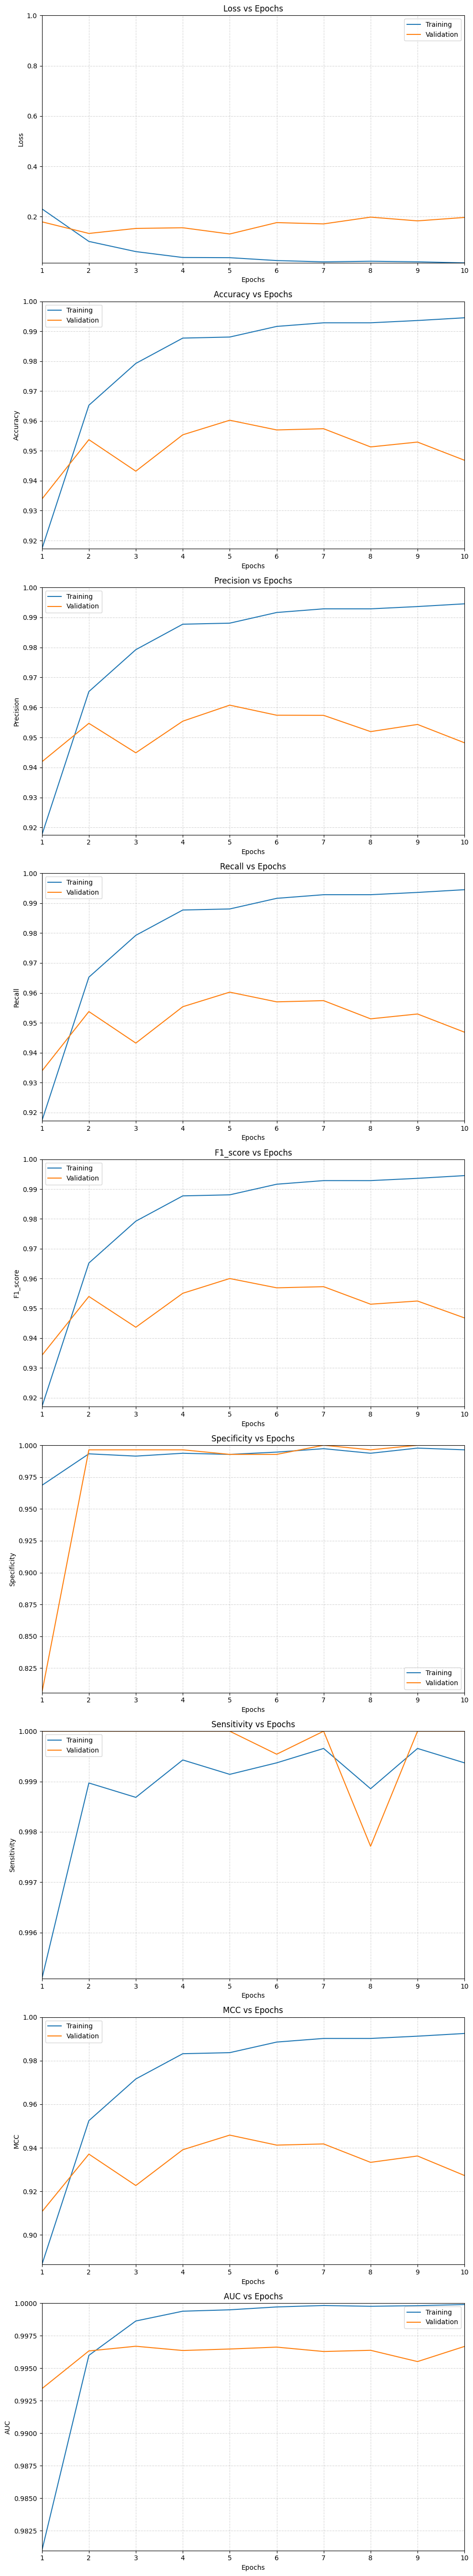

In [11]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        label = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Epochs")
        max_m = max(max(train_metric), max(val_metric))
        min_m = min(min(train_metric), min(val_metric))
        ax.set_ylim(min_m if min_m < 0 or max_m > 1 else min_m, math.ceil(max_m))
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

## Test Evaluation

In [12]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
print("Test Metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Testing Model: 100%|██████████| 155/155 [00:23<00:00,  6.54it/s]

Test Metrics:
  loss: 0.1530
  accuracy: 0.9578
  precision: 0.9583
  recall: 0.9578
  f1_score: 0.9576
  specificity: 0.9892
  sensitivity: 1.0000
  mcc: 0.9425
  auc: 0.9956


## Classification Report & Confusion Matrix

                     precision    recall  f1-score   support

Bacterial Pneumonia     1.0000    0.9892    0.9946       278
              COVID     0.9808    0.9862    0.9835       362
       Lung_Opacity     0.9589    0.8918    0.9241       601
             Normal     0.9359    0.9745    0.9548      1019
       Tuberculosis     1.0000    0.9857    0.9928        70
    Viral Pneumonia     0.9562    0.9704    0.9632       135

           accuracy                         0.9578      2465
          macro avg     0.9720    0.9663    0.9688      2465
       weighted avg     0.9583    0.9578    0.9576      2465

There were 104 errors in 2465 tests for an accuracy of  95.78%


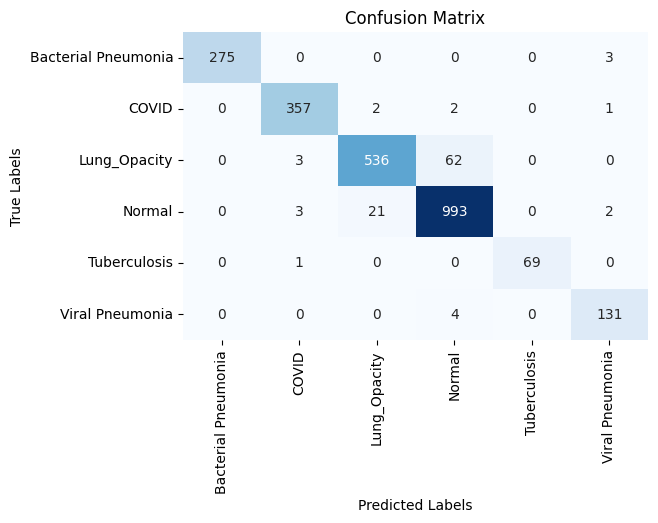

In [13]:
true_labels = np.array(all_targets).astype(int)
predicted_labels = np.argmax(np.array(all_predictions), axis=1).astype(int)
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)
print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}%')

conf_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()